In [1]:
"""
notebook: 1.7.-leibold-data-modeling_randomForest.jpynb

author: Christian Leibold

created/updated at: 2025-12-06

intention: use pipline preprocess data to model withh over- and undersampling + random forest model to create a first baseline model.
           REDUCED DIMENSIONALITY

content:
---------
-> reads in joblib with concatenated data from prior process stept with csv-files for 2019-2023 as base for this notebook 
-> preprocessing with preprocessing_pipeline WITHOUT aggregation
-> pipline with over- and undersampling resampling + random forest model
-> RandomSearchCV + stratifedKFold to optimize hyperparamethers
-> save fitted model and pipeline to local storage
-> PCA to check class seperability
-> first SHAP analysis

"""

'\nnotebook: 1.5.-leibold-data-modeling_randomForest.jpynb\n\nauthor: Christian Leibold\n\ncreated/updated at: 2025-11-30\n\nintention: create preprocessing pipeline to prepare data from concat joblib. \n           use random forest model with smote to create a first baseline model. \n\ncontent:\n---------\n-> reads in joblib with concatenated data from prior process stept with csv-files for 2019-2024 as base for this notebook \n-> create a pipeline with most important preprocessing steps\n-> NEW: use GridSearchCV to optimize hyperparamethers\n-> create random forest model + smote resampling\n-> save model to local storage\n\n'

In [1]:
# classic packages
import pandas as pd
import numpy as np
from joblib import dump, load

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# make custom libraries importable
import sys
sys.path.append('../../library')

# pipeline compatibel classes
from road_accidents_pipeline import RemoveIrrelevantCols         # removes some unnecessary columns
from road_accidents_pipeline import RearrangeCatCols             # bundle veh classes together to higher-tier classes
from road_accidents_pipeline import ConditionalMultiQuantImputer # impute missing values of quantiative variables via distr. on cat var
from road_accidents_pipeline import ConditionalCatImputer        # impute missing values of categorcial variables on target distribution
from road_accidents_pipeline import AggrLocaSplit                # aggregation of loca intersections incl. oneHotEncoding 
from road_accidents_pipeline import SupervisedEncoderWrapper     # wrapper for supervised encoders like CatBoostEncoder or TargetEncoder to make it work in pipeline
from road_accidents_pipeline import RemoveIdCols                 # removes ind_temp_id and acc_num after aggregation
from road_accidents_pipeline import TrigonometricEncoder         # encoding for cyclic variables lice acc_month or acc_hour
from road_accidents_pipeline import SafeColumnSelector           # makes sure only to use existing columns in pipeline

# scaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# encoder
from sklearn.preprocessing import OneHotEncoder, SplineTransformer
from sklearn.preprocessing import FunctionTransformer
from category_encoders import TargetEncoder, CatBoostEncoder

# train_test_split
from sklearn.model_selection import train_test_split

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import make_scorer, f1_score, recall_score
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

import shap

# pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# resampling
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# model classifier
from sklearn.ensemble import RandomForestClassifier

# hyperparameter optimization
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# little helper
from cleaning_utils import distinguish_cols, print_col_categories
import time



In [2]:
# -------------------------------------------------------------------------------------------------
# read in joblib with concatenated data and define which data to keep
# -------------------------------------------------------------------------------------------------
df_ori = load('C:/Users/Christian/Documents/1.0-leibold-data-preprocessing_aggr.joblib')
#df = df_ori.loc[df_ori['acc_year'].between(2019, 2023)]
#df = df_ori.loc[(df_ori['acc_year']==2024)]
#df = df_ori.loc[(df_ori['acc_year']==2024) | (df_ori['acc_year']==2023)]
#df = df.sample(n=20000)
df = df_ori

print("original shape:", df_ori.shape)
print("kept shape:", df.shape)
display(df.head(3))

original shape: (692159, 45)
kept shape: (692159, 45)


,acc_num,ind_place,ind_cat,ind_severity,ind_sex,ind_trip,ind_secu1,ind_secu2,ind_location,ind_action,...,loca_traffic_circul,loca_road_lanes,loca_road_gradient,loca_road_view,loca_road_surface_cond,loca_accident,loca_max_speed,loca_is_intersection,loca_road_counts,loca_max_speed_dif
0,201900000001,2,2,2,2,0,1,0,<NA>,<NA>,...,3,10.0,1,2.0,1.0,1,70.0,0,1,0.0
1,201900000001,1,1,2,2,5,1,0,<NA>,<NA>,...,3,10.0,1,2.0,1.0,1,70.0,0,1,0.0
2,201900000001,1,1,1,1,0,1,0,<NA>,<NA>,...,3,10.0,1,2.0,1.0,1,70.0,0,1,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 692159 entries, 0 to 733874
Data columns (total 45 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   acc_num                 692159 non-null  int64         
 1   ind_place               692159 non-null  int64         
 2   ind_cat                 692159 non-null  int64         
 3   ind_severity            692159 non-null  int64         
 4   ind_sex                 692159 non-null  int64         
 5   ind_trip                692159 non-null  int64         
 6   ind_secu1               691305 non-null  Int64         
 7   ind_secu2               415207 non-null  Int64         
 8   ind_location            379506 non-null  Int64         
 9   ind_action              409030 non-null  Int64         
 10  ind_year                692159 non-null  int64         
 11  ind_age                 692159 non-null  Int64         
 12  ind_age_group           692159 non-

In [4]:
# -------------------------------------------------------------------------------------------------
# data split
# -------------------------------------------------------------------------------------------------
# Separate features and target
X = df.drop(columns=['ind_severity'])   # predictors
y = df['ind_severity']                  # target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (553727, 44)
y_train shape: (553727,)
X_test shape: (138432, 44)
y_test shape: (138432,)


In [5]:
# -------------------------------------------------------------------------------------------------
# check missing values
# -------------------------------------------------------------------------------------------------
missing_vars = X_train.isna().sum()
missing_vars = missing_vars[missing_vars > 0]
print(missing_vars)

ind_secu1                    690
ind_secu2                 221366
ind_location              250084
ind_action                226525
acc_ambient_lightning          9
acc_atmosphere                32
acc_intersection              24
acc_collision_type          2979
veh_impact                   231
veh_maneuver               31724
loca_road_lanes             7862
loca_road_view                49
loca_road_surface_cond        98
loca_max_speed              7708
loca_max_speed_dif          7708
dtype: int64


In [6]:
# -------------------------------------------------------------------------------------------------
# define columns to be operated: read in columns from dictionary for later use in pipeline
# -------------------------------------------------------------------------------------------------
cols_dict = distinguish_cols(df)

cat_cols = cols_dict["categorical"] # Get all categorical variables from cols_dict
missing_cat_cols = [col for col in cat_cols if col in X_train.columns and X_train[col].isna().any()] # Restrict to those with missing values

ohe_cols = cols_dict['oneHot_encoder']
valid_ohe_cols = [col for col in ohe_cols if col in X_train.columns] # Restrict to existing columns


⚠️ Missing columns (ignored): ['loca_road_count']


In [8]:
ohe_cols

['acc_ambient_lightning',
 'acc_urbanization_level',
 'acc_intersection',
 'acc_atmosphere',
 'acc_collision_type',
 'ind_place',
 'ind_cat',
 'ind_sex',
 'ind_trip',
 'ind_location',
 'ind_action',
 'ind_secu1',
 'ind_secu2',
 'ind_age_group',
 'loca_traffic_circul',
 'loca_road_gradient',
 'loca_road_view',
 'loca_accident',
 'loca_road_surface_cond',
 'veh_cat',
 'veh_fixed_obstacle',
 'veh_moving_obstacle',
 'veh_impact',
 'veh_maneuver',
 'veh_motor']

In [7]:
# -------------------------------------------------------------------------------------------------
# Full preprocessing pipeline
# -------------------------------------------------------------------------------------------------
# steps:
# --------------------------------------------------------
# - RemoveIrrelevantCols: Drops columns not useful for prediction.
# - ConditionalMultiQuantImputer: Imputes missing numeric values based on road category.
# - ConditionalCatImputer: Fills missing categorical values conditionally on target distribution.
# - AggrLocaSplit: Aggregates location features for intersections.
# - RemoveIdCols: Removes identifier columns used in aggregation.
# - RearrangeCatCols: merge some classes in veh categorical columns to reduce cardinatliy.
# - ColumnTransformer: Applies cyclic encoding, one-hot, CatBoost encoding, and scaling to features.


# Start timer
start_time = time.time()

# instantiate encoders
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')
catboost_encoder = SupervisedEncoderWrapper(CatBoostEncoder(handle_unknown='value', handle_missing='value'), columns=["acc_municipality"])
cyclical_transformer = TrigonometricEncoder({"acc_hour": 24, "acc_month": 12})

# instantiate Scaler
scaler = MinMaxScaler()

# Combine everything into one pipeline
preprocessing_pipeline = Pipeline([
    # data preparation
    ("remove_cols", RemoveIrrelevantCols(verbose=True)),
    ("remove_id_cols", RemoveIdCols(verbose=True)),

    # imputing
    ("impute_quant", ConditionalMultiQuantImputer(quant_vars=["loca_max_speed", "loca_road_lanes", "loca_max_speed_dif"],cat_var="loca_road_cat")),
    ("impute_cat", ConditionalCatImputer(var_list=cat_cols)),

 
    # encoding & scaling
    ("rearrange_categories", RearrangeCatCols(verbose=True)),
    ("encode_scale", ColumnTransformer([
        ("cyclical", cyclical_transformer, ["acc_hour", "acc_month"]),  
       ("onehot", Pipeline([
            ("select", SafeColumnSelector(cols_dict['oneHot_encoder'])),
            ("encode", ohe_encoder)
        ]), cols_dict['oneHot_encoder']),

        ("catboost", catboost_encoder, ["acc_municipality"]),
        ("scale", scaler, ['loca_road_lanes', 'loca_max_speed', 'loca_max_speed_dif'])
    ], remainder="passthrough"))
    
], verbose=True)


# Fit the pipeline
preprocessing_pipeline.fit(X_train, y_train)

# Transform training and test data
X_train_piped = preprocessing_pipeline.transform(X_train)
X_test_piped = preprocessing_pipeline.transform(X_test)

# # Access the fitted aggregation step
# aggr_step = preprocessing_pipeline.named_steps["aggregate"]

# # Transform y consistently (because the aggregation step reduces row count in X -> so y must also be reduced to avoid mismatch error)
# y_train_piped = aggr_step.transform_y(X_train, y_train)
# y_test_piped  = aggr_step.transform_y(X_test, y_test)


# End timer
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"⏱️ Preprocessing Pipeline fit completed in {elapsed_minutes:.2f} minutes")


[Pipeline] ....... (step 1 of 6) Processing remove_cols, total=   0.1s
ℹ️ RemoveIdCols -> The following columns were not found and skipped: ['ind_temp_id']
[Pipeline] .... (step 2 of 6) Processing remove_id_cols, total=   0.1s
[Pipeline] ...... (step 3 of 6) Processing impute_quant, total= 1.5min
ℹ️ ConditionalCatImputer -> Column 'ind_location' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_action' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_secu2' not found, skipping.
[Pipeline] ........ (step 4 of 6) Processing impute_cat, total= 2.4min
[Pipeline]  (step 5 of 6) Processing rearrange_categories, total=   0.3s
[Pipeline] ...... (step 6 of 6) Processing encode_scale, total=   3.2s
ℹ️ RemoveIdCols -> The following columns were not found and skipped: ['ind_temp_id']
ℹ️ RemoveIdCols -> The following columns were not found and skipped: ['ind_temp_id']
⏱️ Preprocessing Pipeline fit completed in 8.33 minutes


In [8]:
# --------------------------------------------------------------------------------------------------
# modelling with pipeline
# --------------------------------------------------------------------------------------------------
# Start timer
start_time = time.time()

# build pipeline with resampling and RandomForestClassifier
model_pipeline = ImbPipeline([
                    ('under', RandomUnderSampler(random_state=42)),
                    ('over', RandomOverSampler(random_state=42)),    
                    ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))
                ])

# Define parameter distributions
param_dist = {
    "clf__max_depth": [10, 15],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt", "log2"],
    "clf__class_weight": ["balanced"]
}

# define StratifiedKFold
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)           

# RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_dist,
    n_iter=10,         
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# fit the search object 
search.fit(X_train_piped, y_train)

# print best parameters and scores
print("Best parameters:", search.best_params_)
print("Best CV score:", search.best_score_)

# access the best pipeline including SMOTEEN + RandomForest and take only the model step
best_rf = search.best_estimator_.named_steps["clf"]
        
# Predict on test and train set
y_test_pred_best = best_rf.predict(X_test_piped)
y_train_pred_best = best_rf.predict(X_train_piped)

y_test_proba = best_rf.predict_proba(X_test_piped)


# End timer
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"⏱️ model fitting completed in {elapsed_minutes:.2f} minutes")



Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best parameters: {'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_features': 'sqrt', 'clf__max_depth': 15, 'clf__class_weight': 'balanced'}
Best CV score: 0.4963561383881838
⏱️ model fitting completed in 1.02 minutes


✅ RandomForest Results
Accuracy train: 0.6308325221634488
Accuracy test: 0.6058425797503467

Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.80      0.76     57172
           2       0.73      0.48      0.58     56197
           3       0.41      0.39      0.40     21392
           4       0.14      0.64      0.23      3671

    accuracy                           0.61    138432
   macro avg       0.50      0.58      0.49    138432
weighted avg       0.66      0.61      0.62    138432



Predicted,1,2,3,4
Actual,,,,
1,46019,5501,2622,3030
2,15437,27118,8730,4912
3,2059,4191,8384,6758
4,218,298,808,2347


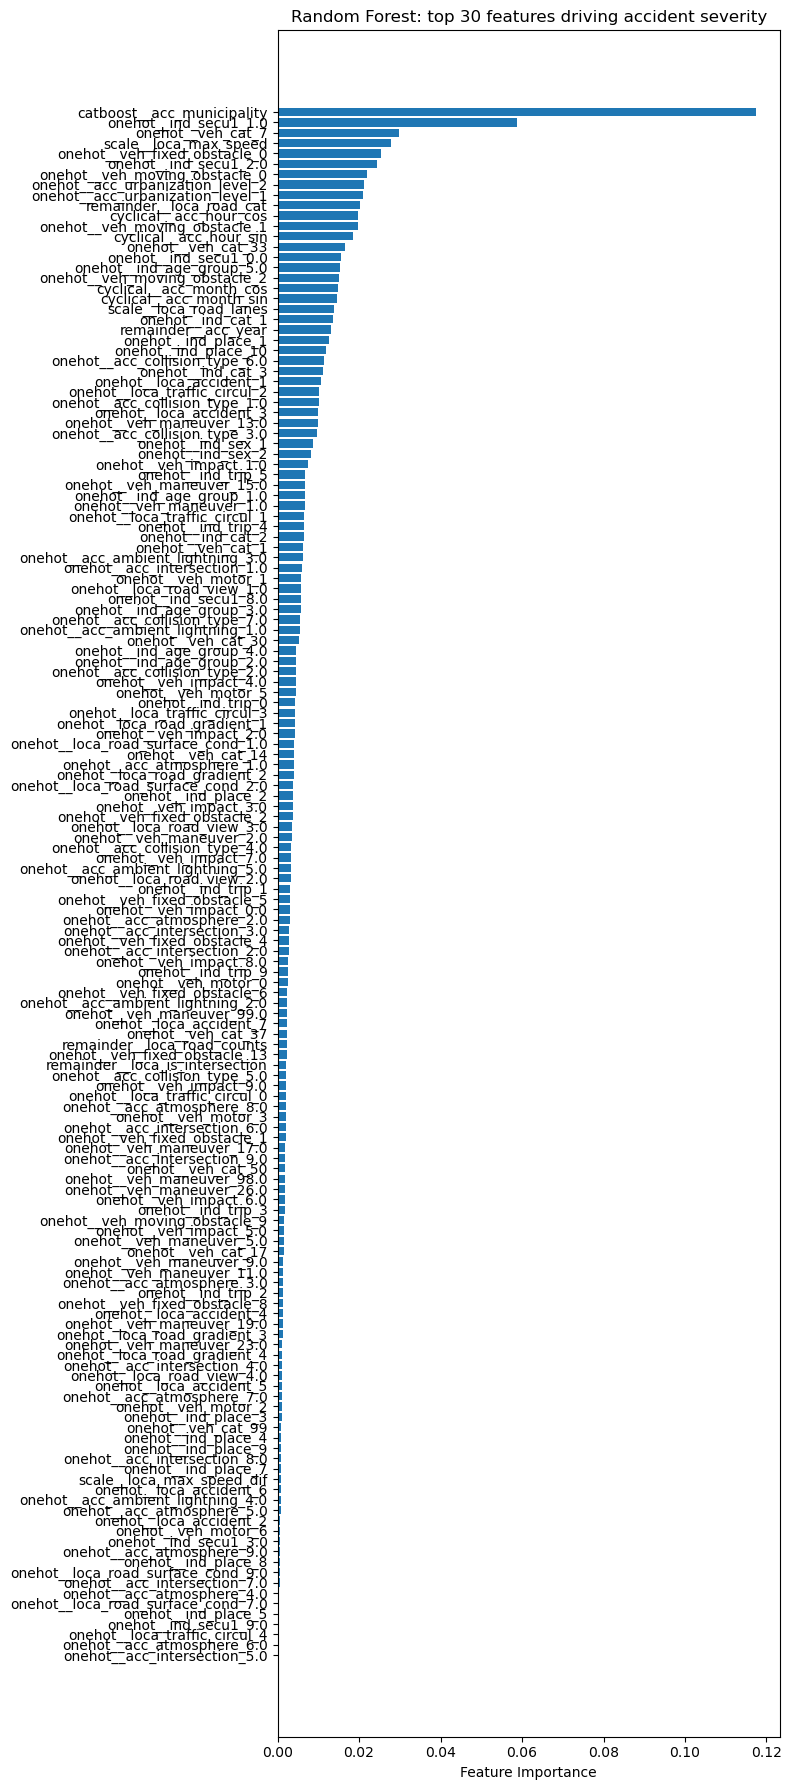

In [9]:
# --------------------------------------------------------------------------------------------------
# Evaluate performance
# --------------------------------------------------------------------------------------------------
print("✅ RandomForest Results")

# accuracy score to check if overfitted
print("Accuracy train:", accuracy_score(y_train, y_train_pred_best))
print("Accuracy test:", accuracy_score(y_test, y_test_pred_best))

# classifiction report
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_best))

# confustion matrix
display(pd.crosstab(y_test, y_test_pred_best, rownames=["Actual"], colnames=["Predicted"]))
#print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


# --------------------------------------------------------------------------------------------------
# Feature importance
# --------------------------------------------------------------------------------------------------
# pipline has np.array as output -> for feature_names a pd.DataFrame must be created to plot feature_importances_
feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()
#feature_names = preprocessing_pipeline.get_feature_names_out()
X_train_piped_df = pd.DataFrame(X_train_piped, columns=feature_names)

# Get feature importances from the trained RandomForest
importances = best_rf.feature_importances_
#feature_names = X_train_smote.columns

# Sort by importance
indices = np.argsort(importances)[::-1][:150]  # top 150

plt.figure(figsize=(8, 18))
plt.barh(range(len(indices)), importances[indices][::-1], align="center", height=0.8)
plt.yticks(range(len(indices)), feature_names[indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Random Forest: top 30 features driving accident severity")
plt.tight_layout()
plt.show()

In [10]:
X_train_piped_df.info(max_cols=180)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553727 entries, 0 to 553726
Data columns (total 164 columns):
 #    Column                              Non-Null Count   Dtype  
---   ------                              --------------   -----  
 0    cyclical__acc_hour_sin              553727 non-null  float64
 1    cyclical__acc_hour_cos              553727 non-null  float64
 2    cyclical__acc_month_sin             553727 non-null  float64
 3    cyclical__acc_month_cos             553727 non-null  float64
 4    onehot__acc_ambient_lightning_1.0   553727 non-null  float64
 5    onehot__acc_ambient_lightning_2.0   553727 non-null  float64
 6    onehot__acc_ambient_lightning_3.0   553727 non-null  float64
 7    onehot__acc_ambient_lightning_4.0   553727 non-null  float64
 8    onehot__acc_ambient_lightning_5.0   553727 non-null  float64
 9    onehot__acc_urbanization_level_1    553727 non-null  float64
 10   onehot__acc_urbanization_level_2    553727 non-null  float64
 11   onehot__acc

In [13]:
# --------------------------------------------------------------------------------------------------
# print out all Feature importances in table
# --------------------------------------------------------------------------------------------------
feature_importances = pd.Series(importances, index=X_train_piped_df.columns).sort_values(ascending=False)
fi_df = feature_importances.to_frame(name="importance")
fi_df = fi_df.sort_values("importance", ascending=False)

pd.set_option("display.max_rows", None)   # show all rows
#print(feature_importances)
display(fi_table)
pd.reset_option("display.max_rows")


NameError: name 'fi_table' is not defined

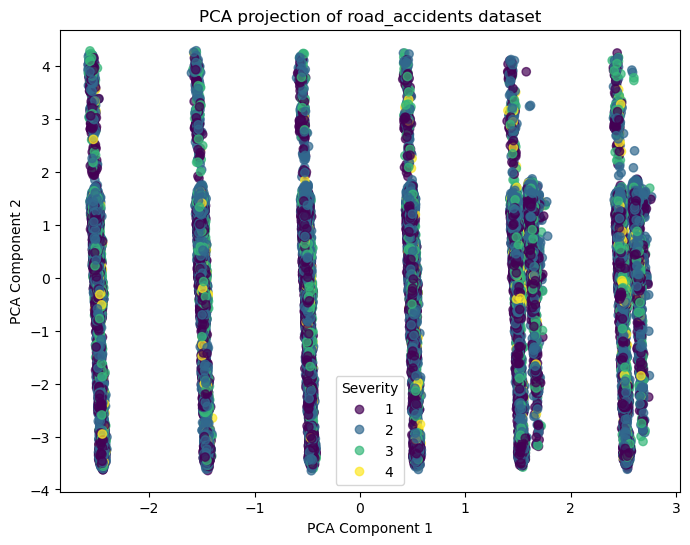

In [11]:
# PCA
pca = PCA(n_components=2, random_state=42)
X_test_pca = pca.fit_transform(X_test_piped)

# Plot with true labels
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=y_test, cmap="viridis", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA projection of road_accidents dataset")
plt.legend(*scatter.legend_elements(), title="Severity")
plt.show()



In [33]:
# --------------------------------------------------------------------------------------------------
# check propabilities for each individual and class
# --------------------------------------------------------------------------------------------------
proba_df = pd.DataFrame(
    y_test_proba,
    columns=[f"class_{c}" for c in best_rf.classes_]
)

proba_df.head()


,class_1,class_2,class_3,class_4
0,0.813020,0.100797,0.038053,0.048131
1,0.355513,0.289563,0.248365,0.106560
2,0.008383,0.771361,0.192740,0.027517
3,0.017831,0.545638,0.316783,0.119749
4,0.889629,0.048518,0.033013,0.028840


In [14]:
# --------------------------------------------------------------------------------------------------
# safe fitted model
# --------------------------------------------------------------------------------------------------
dump(best_rf, "../../models/model_rf_over_under_2019_2024.joblib", compress=3)

#dump(best_rf, "C:/Users/Christian/Documents/model_rf_over_under_2019_2023.joblib", compress=3)
#dump(best_rf, "C:/Users/Christian/Documents/model_rf_over_under_2019_2023_v2.joblib")


['../../models/model_rf_over_under_2019_2024.joblib']

In [13]:
# --------------------------------------------------------------------------------------------------
# safe fitted pipeline
# --------------------------------------------------------------------------------------------------
dump(preprocessing_pipeline, "../../models//pipeline_rf_over_under_2019_2024.pkl", compress=3)

#dump(preprocessing_pipeline, "C:/Users/Christian/Documents/pipeline_rf_over_under_2019_2023.pkl", compress=3)

['../../models//pipeline_rf_over_under_2019_2024.pkl']

In [15]:
# --------------------------------------------------------------------------------------------------
# stratified sample for SHAP values 
# --------------------------------------------------------------------------------------------------
# stratified sample for model explaining
X_sub, _, y_sub, _ = train_test_split(X, y, train_size=30000, stratify=y, random_state=42)

# transform sample the EXACT same way like the fitted model -> very important, otherwise SHAP values do not work
X_sub_clean = preprocessing_pipeline.transform(X_sub)



ℹ️ RemoveIdCols -> The following columns were not found and skipped: ['ind_temp_id']


In [16]:
# OLD SHAP explainer
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_sub_clean, approximate=True)


In [17]:
# feature names from pipeline
feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()

# create dataframe to pass later to NEW SHAP explainer object
X_sub_df = pd.DataFrame(X_sub_clean, columns=feature_names)


In [15]:
X_sub_df.info(max_cols=180)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 163 columns):
 #    Column                              Non-Null Count  Dtype  
---   ------                              --------------  -----  
 0    cyclical__acc_hour_sin              30000 non-null  float64
 1    cyclical__acc_hour_cos              30000 non-null  float64
 2    cyclical__acc_month_sin             30000 non-null  float64
 3    cyclical__acc_month_cos             30000 non-null  float64
 4    onehot__acc_ambient_lightning_1.0   30000 non-null  float64
 5    onehot__acc_ambient_lightning_2.0   30000 non-null  float64
 6    onehot__acc_ambient_lightning_3.0   30000 non-null  float64
 7    onehot__acc_ambient_lightning_4.0   30000 non-null  float64
 8    onehot__acc_ambient_lightning_5.0   30000 non-null  float64
 9    onehot__acc_urbanization_level_1    30000 non-null  float64
 10   onehot__acc_urbanization_level_2    30000 non-null  float64
 11   onehot__acc_intersection_1

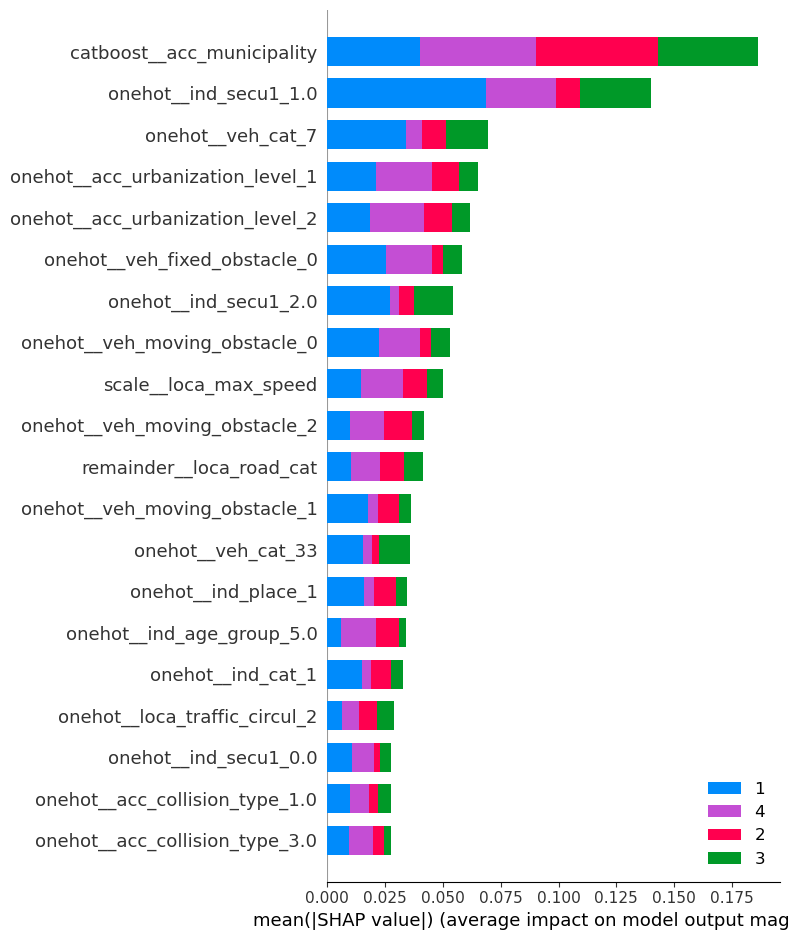

In [18]:
# OLD SHAP summary_plot over all classes
shap.summary_plot(shap_values, X_sub_df, plot_type="bar", class_names=best_rf.classes_ , title="Top 50 Features Random Forest Model", max_display=20)



In [19]:
# NEW SHAP values -> whatch out: explainer object different from TreeExplainer!!
# ----------------------------
feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()
X_sub_df = pd.DataFrame(X_sub_clean, columns=feature_names)

# Explainer object of new SHAP api
explainer_new = shap.Explainer(best_rf, X_sub_clean)

# SHAP values with DATAFRAME as input (important to retain feature names)
shap_values_new = explainer_new(X_sub_df, approximate=True)


In [20]:
class ShapOneHotAggregator:
    """
    Aggregate SHAP values of one-hot and cyclical encoded features back to their original feature.
    """

    def __init__(self, feature_names, prefix="onehot__", cyclical_prefix="cyclical__"):
        self.feature_names = feature_names
        self.prefix = prefix
        self.cyclical_prefix = cyclical_prefix
        self.groups = self._build_groups()

    def _build_groups(self):
        groups = {}
        for fname in self.feature_names:
            if fname.startswith(self.prefix):
                # One-hot encoded
                base = fname[len(self.prefix):]
                parent = base.rsplit("_", 1)[0]
                groups.setdefault(parent, []).append(fname)
            elif fname.startswith(self.cyclical_prefix):
                # Cyclical encoded (_sin/_cos)
                parent = fname.rsplit("_", 1)[0]  # remove _sin/_cos
                groups.setdefault(parent, []).append(fname)
            else:
                # Continuous or already atomic
                groups.setdefault(fname, [fname])
        return groups

    def aggregate(self, shap_values, data, base_values=None):
        has_classes = shap_values.ndim == 3
        agg_list, agg_feature_names = [], []

        for parent, children in self.groups.items():
            idxs = [self.feature_names.index(ch) for ch in children]
            if has_classes:
                agg_vals = shap_values[:, idxs, :].sum(axis=1)
            else:
                agg_vals = shap_values[:, idxs].sum(axis=1)
            agg_list.append(agg_vals)
            agg_feature_names.append(parent)

        agg_values = np.stack(agg_list, axis=1) if has_classes else np.column_stack(agg_list)

        # Collapse data
        X_df = pd.DataFrame(data, columns=self.feature_names)
        agg_data = pd.DataFrame(index=X_df.index)
        for parent, children in self.groups.items():
            if parent.startswith("cyclical__") and len(children) == 2:
                # Keep both sin/cos values but collapse into one parent vector
                agg_data[parent] = np.sqrt(X_df[children[0]]**2 + X_df[children[1]]**2)
            elif len(children) > 1 and children[0].startswith(self.prefix):
                # One-hot collapse
                agg_data[parent] = X_df[children].idxmax(axis=1).str.replace(f"{parent}_", "")
            else:
                agg_data[parent] = X_df[children[0]]

        explainer_agg = shap.Explanation(
            values=agg_values,
            base_values=base_values,
            data=agg_data.values,
            feature_names=agg_feature_names
        )
        return explainer_agg, self.groups

In [21]:
aggregator = ShapOneHotAggregator(shap_values_new.feature_names)
explainer_agg, mapping = aggregator.aggregate(shap_values_new.values, shap_values_new.data)

# Now explainer_agg.values and explainer_agg.data have matching shapes
print(explainer_agg.values.shape)  # (n_samples, n_features_new, n_classes)
print(explainer_agg.data.shape)    # (n_samples, n_features_new)



(30000, 32, 4)
(30000, 32)


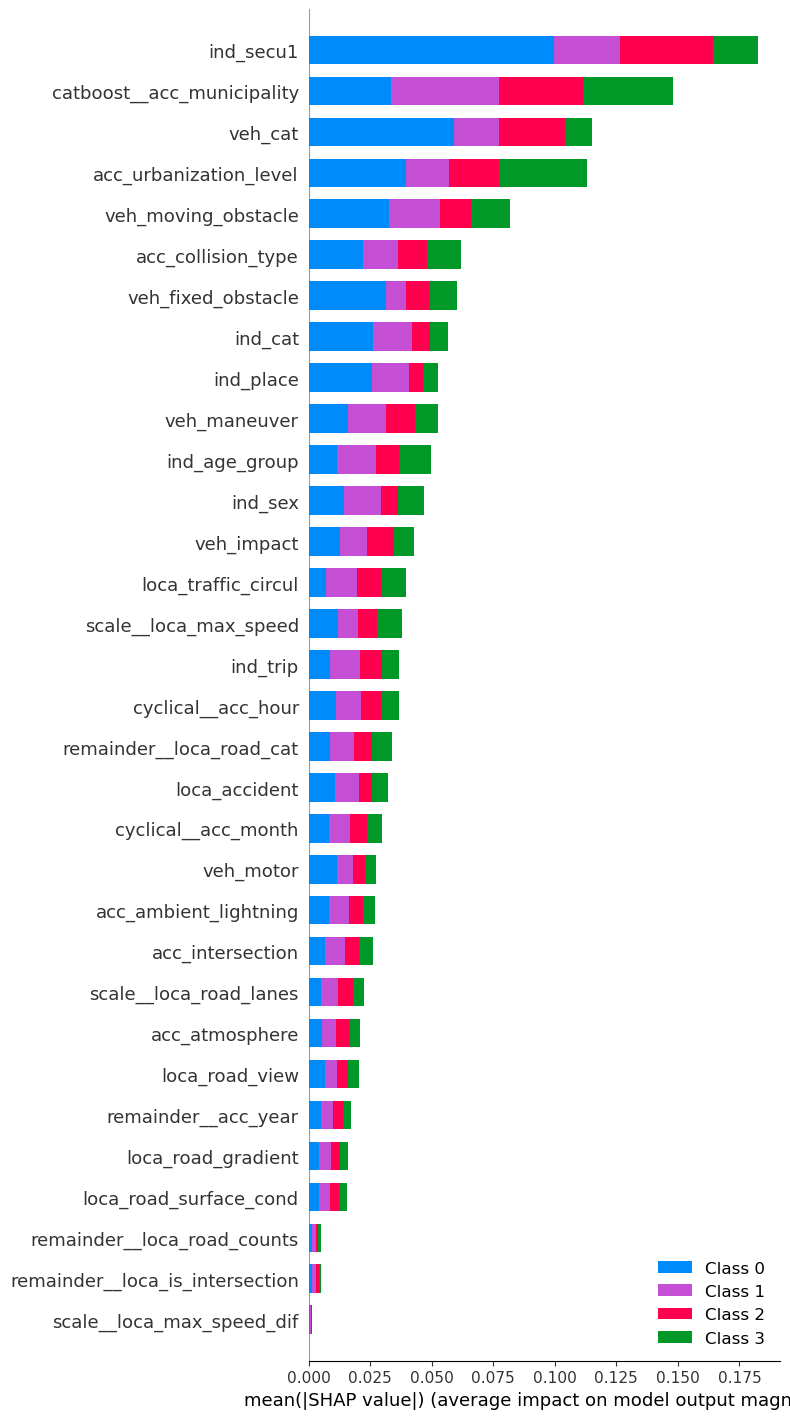

In [22]:
# Plot aggregated features
shap.summary_plot(
    explainer_agg.values,
    #explainer_agg.data,
    feature_names=explainer_agg.feature_names,
    plot_type="bar",
    max_display=50
)